<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Автор материала: Юрий Кашницкий, программист-исследователь Mail.Ru Group <br> 

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8 (демо)
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://docs.google.com/forms/d/1xlbc0CaUaNpVs-fhxkHUe61AtsvS_aDqQ0CLFxs6UDA) для ответов.

## План домашнего задания
    1. Линейная регрессия и SGD
    2. Логистическая регрессия и SGD
    3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

##  1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [2]:
class SGDRegressor(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    
    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]  
                w = new_w.copy()
                
                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
                
        return self
                  
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)                  

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [3]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

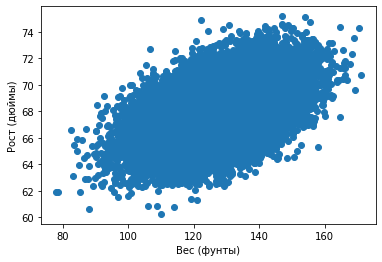

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [5]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [8]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.58s/it]


SGDRegressor(eta=0.001, n_epochs=3)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

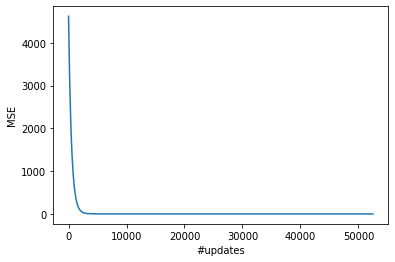

In [9]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_)
plt.xlabel('#updates')
plt.ylabel('MSE');

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [10]:
''' ВАШ КОД ЗДЕСЬ '''
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643627, array([67.9898497 ,  0.94447605]))

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

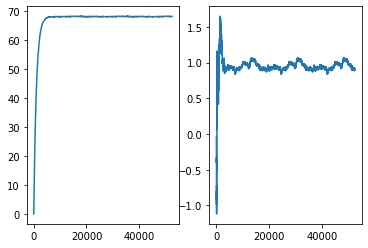

In [11]:
''' ВАШ КОД ЗДЕСЬ '''
plt.subplot(121)
plt.plot(range(len(sgd_reg.weights_)), 
         [w[0] for w in sgd_reg.weights_]);
plt.subplot(122)
plt.plot(range(len(sgd_reg.weights_)), 
         [w[1] for w in sgd_reg.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [12]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_holdout_mse = mean_squared_error(y_valid, 
                                        sgd_reg.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [13]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, 
                                        lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.670830767667635

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

## 2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [14]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [15]:
class SGDClassifier(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    
    def __init__(self, eta=1e-3, n_epochs=10, C=1):
        self.eta = eta
        self.n_epochs = n_epochs
        self.C = C
        self.loss_ = []
        self.weights_ = []
        
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        w = np.zeros(X.shape[1])
        
        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):
                
                new_w = w.copy()
                new_w[0] += self.eta * (self.C*y[i]*sigma(- y[i]*w.dot(X[i, :])))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (self.C*y[i]*X[i, j]*sigma(- y[i]*w.dot(X[i, :]))-w[j])  
                w = new_w.copy()
                
                self.weights_.append(w)
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                
        self.w_ = self.weights_[np.argmin(self.loss_)]
                
        return self
                  
    def predict_proba(self, X):
        X = sigma(np.hstack([np.ones([X.shape[0], 1]), X]).dot(self.w_))
        
        return np.vstack([1-X, X]).T
    
    def predict(self, X):
        X = self.predict_proba(X)
        return [-1 if i < 0.5 else 1 for i in X[:,1]]                       

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [16]:
from sklearn.datasets import load_breast_cancer

In [17]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [20]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_class = SGDClassifier(n_epochs=3, C=1)
sgd_class.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.74it/s]


SGDClassifier(C=1, eta=0.001, n_epochs=3)

Постройте график изменения log_loss.

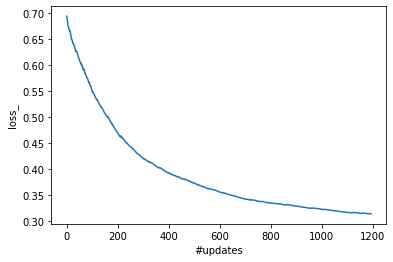

In [21]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(range(len(sgd_class.loss_)), sgd_class.loss_)
plt.xlabel('#updates')
plt.ylabel('loss_');

In [22]:
np.min(sgd_class.loss_), sgd_class.w_

(0.3143601842726882,
 array([ 0.1150394 , -0.10567889, -0.07360741, -0.10722945, -0.10111613,
        -0.04387458, -0.07419414, -0.09720555, -0.11456287, -0.03948751,
         0.01509647, -0.07239635,  0.00681744, -0.06982129, -0.06702277,
         0.01914684, -0.02202813, -0.01456648, -0.04263819,  0.01486485,
         0.01453791, -0.11758403, -0.08491493, -0.11784667, -0.1077611 ,
        -0.06993637, -0.08756799, -0.10164763, -0.12086001, -0.07505301,
        -0.05015634]))

In [23]:
list(cancer.feature_names)[np.argmax((-sgd_class.w_[1:]))]

'worst concave points'

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [24]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_class = SGDClassifier(n_epochs=10, C=1000)
sgd_class.fit(X_train_scaled, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


SGDClassifier(C=1000, eta=0.001, n_epochs=10)

In [25]:
np.min(sgd_class.loss_), sgd_class.w_

(0.04878601036435233,
 array([ 3.09122261, -1.6575532 , -3.41387355, -1.40982226, -1.66493135,
        -0.17720257,  1.97826991, -3.56690964, -3.54327573,  0.4185013 ,
         2.86034954, -4.5318188 ,  2.7917743 , -2.57528861, -3.15458401,
         0.60303196,  4.53505884,  0.29303788,  0.07966677, -0.52020555,
         4.6606677 , -2.92418606, -4.05156371, -1.63955219, -2.51138523,
        -1.8587154 , -0.72097361, -5.10734277, -1.97909982, -1.59910147,
        -2.29297817]))

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [26]:
''' ВАШ КОД ЗДЕСЬ '''
list(cancer.target_names), list(cancer.feature_names)

(['malignant', 'benign'],
 ['mean radius',
  'mean texture',
  'mean perimeter',
  'mean area',
  'mean smoothness',
  'mean compactness',
  'mean concavity',
  'mean concave points',
  'mean symmetry',
  'mean fractal dimension',
  'radius error',
  'texture error',
  'perimeter error',
  'area error',
  'smoothness error',
  'compactness error',
  'concavity error',
  'concave points error',
  'symmetry error',
  'fractal dimension error',
  'worst radius',
  'worst texture',
  'worst perimeter',
  'worst area',
  'worst smoothness',
  'worst compactness',
  'worst concavity',
  'worst concave points',
  'worst symmetry',
  'worst fractal dimension'])

In [27]:
list(cancer.feature_names)[np.argmax(-(sgd_class.w_[1:]))]

'worst concavity'

In [28]:
len(sgd_class.w_), len(cancer.feature_names), np.argmax(-sgd_class.w_[1:])

(31, 30, 26)

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [29]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_holdout_loss = log_loss(
    y_valid, sgd_class.predict_proba(X_valid_scaled))
sgd_holdout_loss

0.43441107939578316

In [30]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
logit = LogisticRegression(random_state=17).fit(X_train_scaled, y_train)
print(logit.coef_, logit.intercept_)
logit_holdout_loss = log_loss(y_valid, logit.predict_proba(X_valid_scaled))
logit_holdout_loss

[[-0.34623157 -0.57202271 -0.31920136 -0.40073449 -0.05914097  0.1942733
  -1.01603583 -0.95503531 -0.06247663  0.1288474  -1.23173752  0.31305906
  -0.78440347 -0.88735818  0.10591764  0.92297937 -0.16883996  0.04198707
   0.28309492  0.93508654 -0.992932   -1.15158828 -0.77683843 -0.89822274
  -0.61709798 -0.05534737 -1.09965137 -0.77500329 -0.7249302  -0.39432843]] [0.66937188]


0.10855223162447461

In [31]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_holdout_roc_auc_score = roc_auc_score(
    y_valid, sgd_class.predict_proba(X_valid_scaled)[:,1])
sgd_holdout_roc_auc_score

0.9763040238450075

In [32]:
logit_holdout_roc_auc_score = roc_auc_score(y_valid, logit.predict_proba(X_valid_scaled)[:,1])
logit_holdout_roc_auc_score

0.9885245901639343

In [33]:
from sklearn.metrics import accuracy_score
sgd_holdout_acur = accuracy_score(y_valid, sgd_class.predict(X_valid_scaled))
sgd_holdout_acur

0.9707602339181286

In [34]:
logit_holdout_acc_score = accuracy_score(y_valid, logit.predict(X_valid_scaled))
logit_holdout_acc_score

0.9766081871345029

## 3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://drive.google.com/open?id=1xq4l5c0JrcxJdyBwJWvy0u9Ad_pvkJ1l).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [36]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
import os

In [37]:
# поменяйте путь к файлу
PATH_TO_DATA = 'c:/Users\Виталий\Documents\Python Scripts\mlcourse.ai-master\data\imdb_reviews'
reviews_train = load_files(os.path.join(PATH_TO_DATA, 'train'))
text_train, y_train = reviews_train.data, reviews_train.target

In [38]:
reviews_test = load_files(os.path.join(PATH_TO_DATA, 'test'))
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [39]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

Wall time: 25.6 s


In [40]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [41]:
''' ВАШ КОД ЗДЕСЬ '''
RANDOM_SEED = 17
sgd_logit = SGDClassifier(random_state=RANDOM_SEED)

In [42]:
%%time
sgd_logit.fit(X_train, y_train)

Wall time: 1.69 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=17, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
#sgd_logit_holdout_roc_auc_score = roc_auc_score(
#    y_test, sgd_logit.predict_proba(X_test)[:,1])
#sgd_logit_holdout_roc_auc_score

In [48]:
sgd_logit_holdout_auc_score = accuracy_score(
    y_test, sgd_logit.predict(X_test))
sgd_logit_holdout_auc_score

0.88852

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [49]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_logit = SGDClassifier(max_iter=100,
                          loss='log', random_state=RANDOM_SEED)

In [50]:
%%time
sgd_logit.fit(X_train, y_train)

Wall time: 1.36 s


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [51]:
sgd_logit_holdout_roc_auc_score = roc_auc_score(
    y_test, sgd_logit.predict_proba(X_test)[:,1])
sgd_logit_holdout_roc_auc_score

0.9529982944

In [55]:
logit = LogisticRegression(random_state=17)

In [56]:
%%time
logit.fit(X_train, y_train)

Wall time: 25 s


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
logit_holdout_roc_auc_score = roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])
logit_holdout_roc_auc_score

0.9577016000000002

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5